<div style="
  width: 100%;
  padding: 14px 18px;
  margin: 8px 0 16px 0;
  border-radius: 12px;
  background: linear-gradient(135deg, #0f172a 0%, #111827 55%, #0b1220 100%);
  border: 1px solid rgba(255,255,255,0.10);
  box-shadow: 0 6px 18px rgba(0,0,0,0.28);
  text-align: center;
  font-family: 'Segoe UI', Arial, sans-serif;
">

  <div style="
    display: inline-block;
    padding: 4px 10px;
    border-radius: 999px;
    background: rgba(255,255,255,0.08);
    border: 1px solid rgba(255,255,255,0.12);
    color: rgba(255,255,255,0.85);
    font-size: 11px;
    letter-spacing: 0.5px;
    text-transform: uppercase;
    margin-bottom: 8px;
  ">
    Understanding Artificial Intelligence • Summative Assessment
  </div>

  <div style="
    color: #ffffff;
    font-size: 22px;
    font-weight: 800;
    line-height: 1.2;
    margin: 0;
  ">
    COMPONENT ONE
  </div>

  <div style="
    color: rgba(255,255,255,0.90);
    font-size: 15px;
    font-weight: 600;
    line-height: 1.3;
    margin-top: 6px;
  ">
    Predicting Customer Spending Behaviour in Streaming Services
  </div>

  <div style="
    width: 80px;
    height: 3px;
    margin: 12px auto 0 auto;
    border-radius: 999px;
    background: rgba(255,255,255,0.7);
  "></div>
</div>


## Component One (a): Single-Feature Regression for Monthly Spend


In [1]:
# Pseudocode: Load the streaming dataset from the current notebook folder.

import pandas as pd
from pathlib import Path

# Find a file that starts with "streaming" in the current folder
root = Path(".")
candidates = sorted([p for p in root.glob("streaming*") if p.is_file()])

if not candidates:
    raise FileNotFoundError(
        "I couldn't find a file starting with 'streaming' in the notebook folder. "
        "Make sure your dataset filename starts with 'streaming' (e.g., streaming.csv)."
    )

data_path = candidates[0]
print("Using dataset file:", data_path)

# Read csv (most Kaggle datasets are csv)
df = pd.read_csv(data_path)

df.head()

Using dataset file: Streaming.csv


,Customer_ID,Age,Gender,Subscription_Length,Region,Payment_Method,Support_Tickets_Raised,Satisfaction_Score,Discount_Offered,Last_Activity,Monthly_Spend,Churned
0,CUST000001,56.0,Male,54,South,PayPal,0,9.0,6.42,319,62.11,1
1,CUST000002,69.0,Female,21,East,Debit Card,1,2.0,13.77,166,37.27,1
2,CUST000003,46.0,Female,49,East,PayPal,3,8.0,19.91,207,61.82,0
3,CUST000004,32.0,Male,47,West,Debit Card,3,1.0,13.39,108,40.96,1
4,CUST000005,60.0,Male,6,East,Credit Card,2,NaN,13.18,65,45.97,0


In [2]:
# Pseudocode: Check columns and confirm the target column Monthly Spend exists.

print("Rows, Columns:", df.shape)
print("\nColumns:\n", df.columns)

target_col = "Monthly_Spend"
if target_col not in df.columns:
    raise KeyError(
        f"'{target_col}' was not found. Check the exact column name in df.columns "
        "and update target_col accordingly."
    )

# Ensure target is numeric
df[target_col] = pd.to_numeric(df[target_col], errors="coerce")

print("\nMissing values in target:", df[target_col].isna().sum())
df[[target_col]].describe()

Rows, Columns: (5000, 12)

Columns:
 Index(['Customer_ID', 'Age', 'Gender', 'Subscription_Length', 'Region',
       'Payment_Method', 'Support_Tickets_Raised', 'Satisfaction_Score',
       'Discount_Offered', 'Last_Activity', 'Monthly_Spend', 'Churned'],
      dtype='object')

Missing values in target: 0


,Monthly_Spend
count,5000.000000
mean,46.619784
std,9.522140
min,-5.060000
25%,39.897500
50%,46.625000
75%,53.210000
max,137.310000


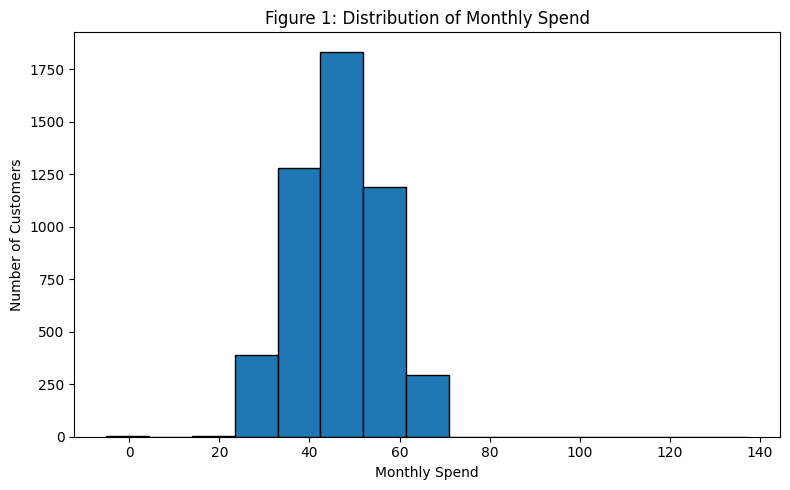

In [5]:
#Clean visualisation of Monthly Spend distribution

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.hist(
    df[target_col].dropna(),
    bins=15,             
    edgecolor="black"     
)

plt.xlabel("Monthly Spend")
plt.ylabel("Number of Customers")
plt.title("Figure 1: Distribution of Monthly Spend")

plt.tight_layout()
plt.savefig("Figure_1_Monthly_Spend_Distribution.png", dpi=300)
plt.show()

In [6]:
# Pseudocode: Select all numeric columns as candidate single-feature predictors.

import numpy as np

numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()

# Remove the target from candidate predictors
numeric_features = [c for c in numeric_cols if c != target_col]

print("Number of numeric feature candidates:", len(numeric_features))
print("Numeric feature candidates:\n", numeric_features)

Number of numeric feature candidates: 7
Numeric feature candidates:
 ['Age', 'Subscription_Length', 'Support_Tickets_Raised', 'Satisfaction_Score', 'Discount_Offered', 'Last_Activity', 'Churned']


In [7]:
# Pseudocode: For each numeric feature, fit linear and polynomial models and compare test performance.

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

results = []

# Keep rows where target and each feature are valid
base_df = df[[target_col] + numeric_features].copy()

# Split once for fair comparison across features
train_df, test_df = train_test_split(base_df, test_size=0.2, random_state=42)

for feature in numeric_features:
    train_sub = train_df[[feature, target_col]].dropna()
    test_sub  = test_df[[feature, target_col]].dropna()

    X_train = train_sub[[feature]]
    y_train = train_sub[target_col]
    X_test  = test_sub[[feature]]
    y_test  = test_sub[target_col]

    # Linear model
    linear_model = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("reg", LinearRegression())
    ])
    linear_model.fit(X_train, y_train)
    pred_lin = linear_model.predict(X_test)

    lin_mae = mean_absolute_error(y_test, pred_lin)
    lin_rmse = np.sqrt(mean_squared_error(y_test, pred_lin))
    lin_r2 = r2_score(y_test, pred_lin)

    results.append({
        "Feature": feature,
        "Model": "Linear",
        "MAE": lin_mae,
        "RMSE": lin_rmse,
        "R2": lin_r2
    })

    # Polynomial models (degree 2 and 3)
    for deg in [2, 3]:
        poly_model = Pipeline(steps=[
            ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
            ("scaler", StandardScaler()),
            ("reg", LinearRegression())
        ])
        poly_model.fit(X_train, y_train)
        pred_poly = poly_model.predict(X_test)

        poly_mae = mean_absolute_error(y_test, pred_poly)
        poly_rmse = np.sqrt(mean_squared_error(y_test, pred_poly))
        poly_r2 = r2_score(y_test, pred_poly)

        results.append({
            "Feature": feature,
            "Model": f"Polynomial (deg {deg})",
            "MAE": poly_mae,
            "RMSE": poly_rmse,
            "R2": poly_r2
        })

results_df = pd.DataFrame(results).sort_values(["RMSE", "MAE"], ascending=True)
results_df.head(15)

,Feature,Model,MAE,RMSE,R2
10,Satisfaction_Score,Polynomial (deg 2),4.982673,6.254588,0.576997
11,Satisfaction_Score,Polynomial (deg 3),4.983163,6.255341,0.576895
9,Satisfaction_Score,Linear,4.983709,6.255559,0.576866
3,Subscription_Length,Linear,6.642847,8.051573,0.282882
4,Subscription_Length,Polynomial (deg 2),6.645539,8.056445,0.282014
5,Subscription_Length,Polynomial (deg 3),6.649370,8.061746,0.281069
18,Churned,Linear,6.839265,8.601150,0.181645
19,Churned,Polynomial (deg 2),6.839265,8.601150,0.181645
20,Churned,Polynomial (deg 3),6.839265,8.601150,0.181645
13,Discount_Offered,Polynomial (deg 2),7.421171,9.293517,0.044591


In [8]:
# Pseudocode: For each feature choose the best model, then select the overall best feature for Monthly Spend.

# Best model per feature = lowest RMSE
best_per_feature = (
    results_df.sort_values(["Feature", "RMSE", "MAE"], ascending=[True, True, True])
    .groupby("Feature", as_index=False)
    .first()
    .sort_values(["RMSE", "MAE"], ascending=True)
)

print("Best model per feature (lowest RMSE):")
best_per_feature.head(10)

best_overall = best_per_feature.iloc[0].to_dict()
best_overall


Best model per feature (lowest RMSE):


{'Feature': 'Satisfaction_Score',
 'Model': 'Polynomial (deg 2)',
 'MAE': 4.982672657853177,
 'RMSE': 6.254587822535139,
 'R2': 0.5769970662933752}

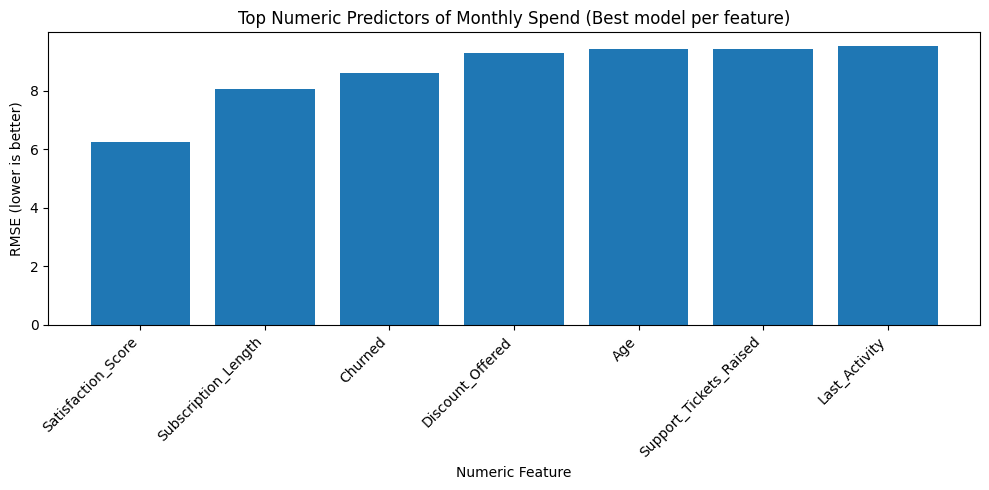

In [9]:
# Pseudocode: Plot RMSE for the best model chosen for each numeric feature.

import matplotlib.pyplot as plt

plot_df = best_per_feature.sort_values("RMSE").head(12)  # show top 12 predictors

plt.figure(figsize=(10, 5))
plt.bar(plot_df["Feature"], plot_df["RMSE"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Numeric Feature")
plt.ylabel("RMSE (lower is better)")
plt.title("Top Numeric Predictors of Monthly Spend (Best model per feature)")
plt.tight_layout()
plt.show()


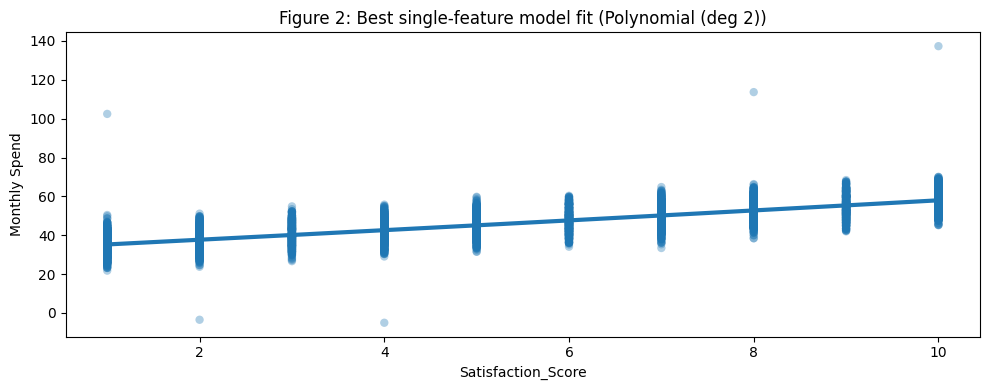

Figure 2 saved as: Figure_2_Best_Single_Feature_Model_Fit.png
Best overall result: {'Feature': 'Satisfaction_Score', 'Model': 'Polynomial (deg 2)', 'MAE': 4.982672657853177, 'RMSE': 6.254587822535139, 'R2': 0.5769970662933752}


In [11]:
# PSEUDOCODE: Plot the best single-feature model fit (based on best_overall) and save as Figure 2.

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Pull the best feature/model from your previous results
best_feature = best_overall["Feature"]
best_model_name = best_overall["Model"]

# Prepare clean data
sub = df[[best_feature, target_col]].dropna()
X = sub[[best_feature]]
y = sub[target_col]

# Rebuild the best model type (consistent with how you evaluated it earlier)
if best_model_name == "Linear":
    best_model = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("reg", LinearRegression())
    ])
elif "Polynomial" in best_model_name:
    # Extract degree from string like "Polynomial (deg 2)"
    deg = int(best_model_name.split("deg")[1].replace(")", "").strip())
    best_model = Pipeline(steps=[
        ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
        ("scaler", StandardScaler()),
        ("reg", LinearRegression())
    ])
else:
    raise ValueError(f"Unexpected best_model_name: {best_model_name}")

# Fit model
best_model.fit(X, y)

# Create smooth prediction input as DataFrame (preserves feature names)
x_line = np.linspace(
    X[best_feature].min(),
    X[best_feature].max(),
    200
)

x_line_df = pd.DataFrame({best_feature: x_line})

y_line = best_model.predict(x_line_df)


# Plot (wide + clean for report)
plt.figure(figsize=(10, 4))
plt.scatter(X[best_feature], y, alpha=0.35, edgecolor="none")
plt.plot(x_line, y_line, linewidth=3)

plt.xlabel(best_feature)
plt.ylabel("Monthly Spend")
plt.title(f"Figure 2: Best single-feature model fit ({best_model_name})")

plt.tight_layout()
plt.savefig("Figure_2_Best_Single_Feature_Model_Fit.png", dpi=300)
plt.show()

print("Figure 2 saved as: Figure_2_Best_Single_Feature_Model_Fit.png")
print("Best overall result:", best_overall)

### Component One (a): Best single numerical predictor of Monthly Spend (Linear vs Non-linear)

**Question aim:**  
To compare regression models that predict **Monthly Spend** using **one numerical feature at a time**, and determine:
1) the **best single numerical predictor** of Monthly Spend, and  
2) whether Monthly Spend fits better with a **linear** or **non-linear** model for each feature.

**Method used:**  
For each numerical feature in the dataset (`Age`, `Subscription_Length`, `Support_Tickets_Raised`, `Satisfaction_Score`, `Discount_Offered`, `Last_Activity`, `Churned`), I trained:
- **Linear Regression**
- **Polynomial Regression (degree 2)**
- **Polynomial Regression (degree 3)**

I evaluated each model using **MAE**, **RMSE**, and **R²**, and selected the best-performing model per feature based on **lowest RMSE**.

---

### Results and interpretation

**Best overall single-feature predictor:**  
- The strongest predictor of Monthly Spend was **`Satisfaction_Score`**.
- The best-performing model for this feature was **Polynomial Regression (degree 2)** with:
  - **RMSE ≈ 6.255**
  - **MAE ≈ 4.983**
  - **R² ≈ 0.577**

This means **Satisfaction_Score alone explains about 57.7% of the variation** in Monthly Spend, which is substantially higher than the other single-feature models tested.

**Does Monthly Spend fit better with linear or non-linear models?**
- For **`Satisfaction_Score`**, the **non-linear polynomial (degree 2)** model performed slightly better than the linear model, showing a mild curved trend.
- For **`Subscription_Length`**, the **linear** model was best (RMSE ≈ 8.052), suggesting a mostly straight-line relationship with Monthly Spend.
- For **`Churned`**, all models performed similarly (RMSE ≈ 8.601), indicating weak predictive power as a single feature.
- For features such as **`Discount_Offered`** and **`Age`**, polynomial models did not produce meaningful improvements over linear regression, and overall performance remained weak (high RMSE and low/near-zero R²).

---

### Conclusion for (a)

- The **best single numerical variable** for predicting Monthly Spend is **`Satisfaction_Score`**.
- Overall, **Monthly Spend is best modelled as non-linear for Satisfaction_Score (degree 2)**, while several other numeric features (e.g., Subscription_Length) are adequately modelled with a **linear relationship** but remain less predictive than Satisfaction_Score.


## Component One (b): Multi-Feature Numerical Regression for Monthly Spend


In [12]:
# Pseudocode: Select only numerical predictors and the Monthly Spend target.

from sklearn.model_selection import train_test_split
import pandas as pd

target_col = "Monthly_Spend"

numeric_features = [
    "Age",
    "Subscription_Length",
    "Support_Tickets_Raised",
    "Satisfaction_Score",
    "Discount_Offered",
    "Last_Activity"
]

X = df[numeric_features]
y = df[target_col]

X.head(), y.head()


(    Age  Subscription_Length  Support_Tickets_Raised  Satisfaction_Score  \
 0  56.0                   54                       0                 9.0   
 1  69.0                   21                       1                 2.0   
 2  46.0                   49                       3                 8.0   
 3  32.0                   47                       3                 1.0   
 4  60.0                    6                       2                 NaN   
 
    Discount_Offered  Last_Activity  
 0              6.42            319  
 1             13.77            166  
 2             19.91            207  
 3             13.39            108  
 4             13.18             65  ,
 0    62.11
 1    37.27
 2    61.82
 3    40.96
 4    45.97
 Name: Monthly_Spend, dtype: float64)

In [13]:
# Pseudocode: Split the data into training and testing sets for fair evaluation.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [14]:
# Pseudocode: Train multi-feature linear regression after filling missing numeric values.

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

multi_linear_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])

multi_linear_model.fit(X_train, y_train)

y_pred_linear = multi_linear_model.predict(X_test)

linear_mae = mean_absolute_error(y_test, y_pred_linear)
linear_rmse = np.sqrt(mean_squared_error(y_test, y_pred_linear))
linear_r2 = r2_score(y_test, y_pred_linear)

print("Multi-Feature Linear Regression")
print("MAE:", linear_mae)
print("RMSE:", linear_rmse)
print("R2:", linear_r2)

Multi-Feature Linear Regression
MAE: 1.3584739578571474
RMSE: 3.208497958313845
R2: 0.88612393388767


In [15]:
# Pseudocode: Train multi-feature polynomial regression after filling missing numeric values.

from sklearn.preprocessing import PolynomialFeatures

multi_poly_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])

multi_poly_model.fit(X_train, y_train)

y_pred_poly = multi_poly_model.predict(X_test)

poly_mae = mean_absolute_error(y_test, y_pred_poly)
poly_rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly))
poly_r2 = r2_score(y_test, y_pred_poly)

print("Multi-Feature Polynomial Regression (deg 2)")
print("MAE:", poly_mae)
print("RMSE:", poly_rmse)
print("R2:", poly_r2)


Multi-Feature Polynomial Regression (deg 2)
MAE: 1.3916972999030326
RMSE: 3.2219579159978617
R2: 0.8851664876909473


In [16]:
# PSEUDOCODE: Compare single-feature vs multi-feature regression models using RMSE (Figure 3).

import pandas as pd
import matplotlib.pyplot as plt

# Build a small summary table from results already computed in your notebook
comparison_df_b = pd.DataFrame({
    "Model": [
        "Best Single Feature (Part a)",
        "Multi-Feature Linear (Part b)",
        "Multi-Feature Polynomial deg 2 (Part b)"
    ],
    "RMSE": [
        best_overall["RMSE"],
        linear_rmse,
        poly_rmse
    ]
}).sort_values("RMSE")

comparison_df_b

,Model,RMSE
1,Multi-Feature Linear (Part b),3.208498
2,Multi-Feature Polynomial deg 2 (Part b),3.221958
0,Best Single Feature (Part a),6.254588


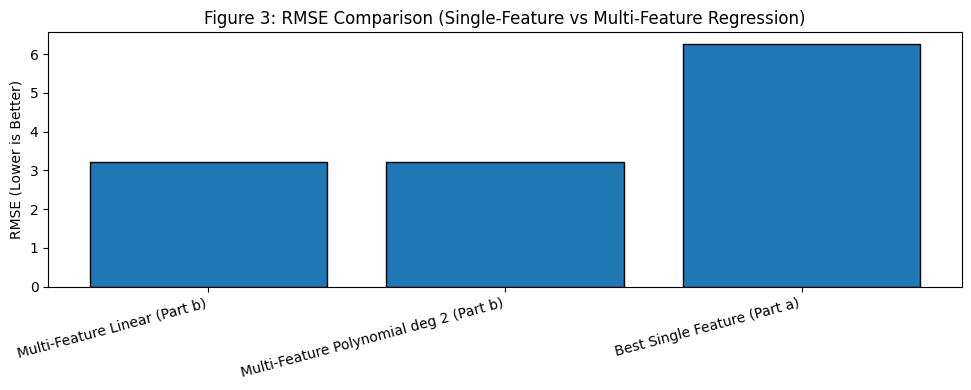

Figure 3 saved as: Figure_3_RMSE_Comparison_Single_vs_Multi_Feature.png


In [17]:
# PSEUDOCODE: Plot RMSE comparison and save as Figure 3.

plt.figure(figsize=(10, 4))

plt.bar(comparison_df_b["Model"], comparison_df_b["RMSE"], edgecolor="black")
plt.ylabel("RMSE (Lower is Better)")
plt.title("Figure 3: RMSE Comparison (Single-Feature vs Multi-Feature Regression)")
plt.xticks(rotation=15, ha="right")

plt.tight_layout()
plt.savefig("Figure_3_RMSE_Comparison_Single_vs_Multi_Feature.png", dpi=300)
plt.show()

print("Figure 3 saved as: Figure_3_RMSE_Comparison_Single_vs_Multi_Feature.png")

## Component One (b): Multi-Feature Numerical Regression for Monthly Spend

**Question aim:**  
To assess whether using **multiple numerical variables simultaneously** improves the prediction of **Monthly Spend**, compared to the best single-feature model identified in part (a).

**Method used:**  
- Six numerical features were used as predictors: `Age`, `Subscription_Length`, `Support_Tickets_Raised`, `Satisfaction_Score`, `Discount_Offered`, and `Last_Activity`.
- Missing values in the numerical predictors were handled using **median imputation** within the modelling pipeline.
- The dataset was split into training and testing subsets.
- Two models were trained and evaluated:
  - **Multi-feature Linear Regression**
  - **Multi-feature Polynomial Regression (degree 2)**
- Model performance was assessed using **MAE**, **RMSE**, and **R²**.

**Results:**  
- The **multi-feature linear regression** model achieved:
  - RMSE ≈ **3.21**
  - R² ≈ **0.886**
- The **multi-feature polynomial regression (degree 2)** model achieved:
  - RMSE ≈ **3.22**
  - R² ≈ **0.885**
- Both multi-feature models substantially outperformed the best single-feature model from part (a), which had an RMSE of approximately **6.25** and R² of **0.58**.

**Interpretation:**  
- Combining multiple numerical features dramatically improved prediction accuracy, reducing RMSE by almost **50%** compared to using a single predictor.
- The linear model slightly outperformed the polynomial model, indicating that once multiple features are included, the relationship between predictors and Monthly Spend is largely **linear**.
- This suggests that Monthly Spend is influenced by a combination of customer behaviour and engagement variables rather than strong non-linear interactions.

**Conclusion for (b):**  
Including multiple numerical features **significantly improves the accuracy** of Monthly Spend prediction. In this case, **multi-feature linear regression** provides the best balance between accuracy and model simplicity.


## Component One (c): Regression Using Numerical and Categorical Features


In [18]:
# Pseudocode: Select numerical and categorical predictors together with the target.

target_col = "Monthly_Spend"

numeric_features = [
    "Age",
    "Subscription_Length",
    "Support_Tickets_Raised",
    "Satisfaction_Score",
    "Discount_Offered",
    "Last_Activity"
]

categorical_features = [
    "Gender",
    "Region",
    "Payment_Method"
]

X = df[numeric_features + categorical_features]
y = df[target_col]

X.head()

,Age,Subscription_Length,Support_Tickets_Raised,Satisfaction_Score,Discount_Offered,Last_Activity,Gender,Region,Payment_Method
0,56.0,54,0,9.0,6.42,319,Male,South,PayPal
1,69.0,21,1,2.0,13.77,166,Female,East,Debit Card
2,46.0,49,3,8.0,19.91,207,Female,East,PayPal
3,32.0,47,3,1.0,13.39,108,Male,West,Debit Card
4,60.0,6,2,NaN,13.18,65,Male,East,Credit Card


In [19]:
# Pseudocode: Split data into training and testing sets.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [20]:
# Pseudocode: Preprocess numerical features with imputation and scaling, and encode categorical features.

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [21]:
# Pseudocode: Train a Random Forest regression model using numerical and categorical features.

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print("Random Forest Regression (Numerical + Categorical)")
print("MAE:", rf_mae)
print("RMSE:", rf_rmse)
print("R2:", rf_r2)


Random Forest Regression (Numerical + Categorical)
MAE: 1.8087548500000004
RMSE: 3.4651657137866443
R2: 0.867175882662487


In [33]:
# Build summary table from already-computed RMSE values
comparison_df_all = pd.DataFrame({
    "Model": [
        "Multi-Feature Linear",
        "Multi-Feature Polynomial (deg 2)",
        "Random Forest Regressor",
        "ANN Regressor"
    ],
    "RMSE": [
        linear_rmse,
        poly_rmse,
        rf_rmse,
        ann_rmse
    ]
}).sort_values("RMSE")

comparison_df_all


,Model,RMSE
0,Multi-Feature Linear,3.208498
1,Multi-Feature Polynomial (deg 2),3.221958
3,ANN Regressor,3.304454
2,Random Forest Regressor,3.465166


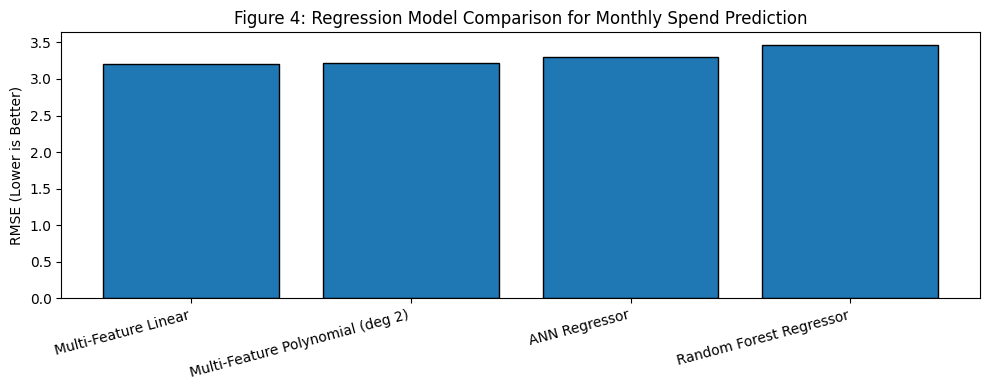

Figure 4 saved as: Figure_4_Regression_Model_Comparison.png


In [34]:
# Plot the overall regression comparison
plt.figure(figsize=(10, 4))

plt.bar(comparison_df_all["Model"], comparison_df_all["RMSE"], edgecolor="black")
plt.ylabel("RMSE (Lower is Better)")
plt.title("Figure 4: Regression Model Comparison for Monthly Spend Prediction")
plt.xticks(rotation=15, ha="right")

plt.tight_layout()
plt.savefig("Figure_4_Regression_Model_Comparison.png", dpi=300)
plt.show()

print("Figure 4 saved as: Figure_4_Regression_Model_Comparison.png")

In [35]:
# Pseudocode: Compare Random Forest results with earlier regression models.

comparison_df_c = pd.DataFrame({
    "Model": [
        "Best Single Feature (Part a)",
        "Multi-Feature Linear Regression (Part b)",
        "Multi-Feature Polynomial Regression (Part b)",
        "Random Forest (Numerical + Categorical)"
    ],
    "RMSE": [
        best_overall["RMSE"],
        linear_rmse,
        poly_rmse,
        rf_rmse
    ],
    "R2": [
        best_overall["R2"],
        linear_r2,
        poly_r2,
        rf_r2
    ]
})

comparison_df_c


,Model,RMSE,R2
0,Best Single Feature (Part a),6.254588,0.576997
1,Multi-Feature Linear Regression (Part b),3.208498,0.886124
2,Multi-Feature Polynomial Regression (Part b),3.221958,0.885166
3,Random Forest (Numerical + Categorical),3.465166,0.867176


In [36]:
# Pseudocode: Extract and rank feature importance from the Random Forest model.

feature_names_num = numeric_features
feature_names_cat = rf_model.named_steps["preprocessor"] \
    .named_transformers_["cat"] \
    .named_steps["onehot"] \
    .get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([feature_names_num, feature_names_cat])

importances = rf_model.named_steps["regressor"].feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

feature_importance_df.head(15)


,Feature,Importance
3,Satisfaction_Score,0.513631
1,Subscription_Length,0.312451
4,Discount_Offered,0.078651
2,Support_Tickets_Raised,0.034786
0,Age,0.021556
5,Last_Activity,0.020723
10,Region_South,0.002473
12,Payment_Method_Credit Card,0.002337
13,Payment_Method_Debit Card,0.002310
8,Region_East,0.002200


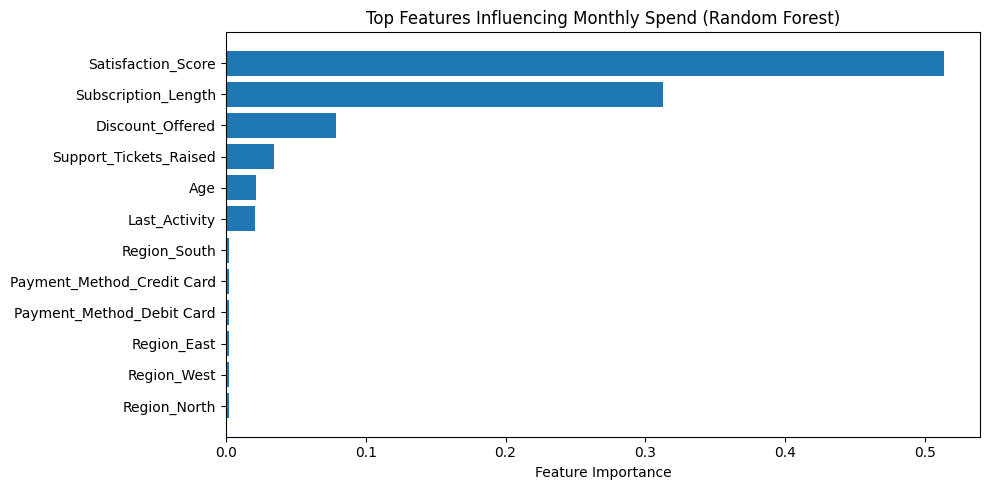

In [37]:
# Pseudocode: Visualise the most important features contributing to Monthly Spend.

import matplotlib.pyplot as plt

top_features = feature_importance_df.head(12)

plt.figure(figsize=(10, 5))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top Features Influencing Monthly Spend (Random Forest)")
plt.tight_layout()
plt.show()


## Component One (c): Regression Using Numerical and Categorical Features

**Question aim:**  
To investigate whether incorporating **categorical variables** alongside numerical features improves the prediction of **Monthly Spend**, compared to models using numerical features only.

**Method used:**  
- Numerical features (`Age`, `Subscription_Length`, `Support_Tickets_Raised`, `Satisfaction_Score`, `Discount_Offered`, `Last_Activity`) were combined with categorical features (`Gender`, `Region`, `Payment_Method`).
- Missing numerical values were handled using **median imputation**, while categorical values were imputed using the most frequent category and encoded using **one-hot encoding**.
- A **Random Forest Regressor** was trained, as it can model non-linear relationships and handle mixed data types effectively.
- Model performance was evaluated using **RMSE** and **R²**, and results were compared with parts (a) and (b).

**Results:**  
- The Random Forest model achieved:
  - **RMSE ≈ 3.47**
  - **R² ≈ 0.87**
- This represents a substantial improvement over the best single-feature model from part (a) (RMSE ≈ 6.25, R² ≈ 0.58).
- However, the Random Forest model performed slightly worse than the **multi-feature linear regression model** from part (b) (RMSE ≈ 3.21, R² ≈ 0.89).

**Feature importance analysis:**  
- The most influential predictor was **Satisfaction_Score** (importance ≈ 0.51), followed by **Subscription_Length** (≈ 0.31).
- Numerical behavioural features dominated the model’s predictions.
- Categorical variables such as **Region**, **Payment_Method**, and **Gender** had very low importance (each < 0.01), indicating minimal additional predictive value.

**Conclusion for (c):**  
Including categorical variables improves performance compared to single-feature models but does **not** outperform the best multi-feature numerical regression model. The results suggest that **Monthly Spend is driven primarily by numerical behavioural factors**, with categorical attributes contributing little additional predictive power in this dataset.


## Component One (d): Artificial Neural Network for Monthly Spend Prediction


In [25]:
# Pseudocode: Select numerical and categorical features and define the target.

target_col = "Monthly_Spend"

numeric_features = [
    "Age",
    "Subscription_Length",
    "Support_Tickets_Raised",
    "Satisfaction_Score",
    "Discount_Offered",
    "Last_Activity"
]

categorical_features = [
    "Gender",
    "Region",
    "Payment_Method"
]

X = df[numeric_features + categorical_features]
y = df[target_col]


In [26]:
# Pseudocode: Split the dataset into training and testing sets.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [27]:
# Pseudocode: Impute missing values and one-hot encode categorical variables.

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [28]:
# Pseudocode: Apply preprocessing and convert features to arrays for neural network input.

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape


((4000, 15), (1000, 15))

In [29]:
# Pseudocode: Define a fully connected neural network using an explicit input layer.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

ann_model = Sequential([
    Input(shape=(X_train_processed.shape[1],)),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(1)
])

ann_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

ann_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Pseudocode: Train the neural network while monitoring validation performance.

history = ann_model.fit(
    X_train_processed,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1737.7850 - mae: 40.2702 - val_loss: 752.5392 - val_mae: 26.3379
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 187.8598 - mae: 10.5696 - val_loss: 15.9020 - val_mae: 2.7582
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 68.7113 - mae: 6.4135 - val_loss: 13.0181 - val_mae: 2.3984
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 65.8664 - mae: 6.2042 - val_loss: 12.4750 - val_mae: 2.2970
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64.0193 - mae: 6.1832 - val_loss: 11.4004 - val_mae: 2.0933
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61.8158 - mae: 6.0761 - val_loss: 11.8440 - val_mae: 2.2522
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61.5173 - mae: 5.9841 - val_loss: 10.8904 - val_mae: 2.0814
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56.6129 - mae: 5.7712 - val_loss: 10.5507 - val_mae: 2.0166
Epoch 9/50
100/100 ━━━━━━━━━━━━━━

In [31]:
# Pseudocode: Evaluate the trained ANN model on the test dataset.

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

y_pred_ann = ann_model.predict(X_test_processed).flatten()

ann_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ann))
ann_r2 = r2_score(y_test, y_pred_ann)

print("ANN Regression Model")
print("RMSE:", ann_rmse)
print("R2:", ann_r2)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
ANN Regression Model
RMSE: 3.3044536452364413
R2: 0.8792107598361146


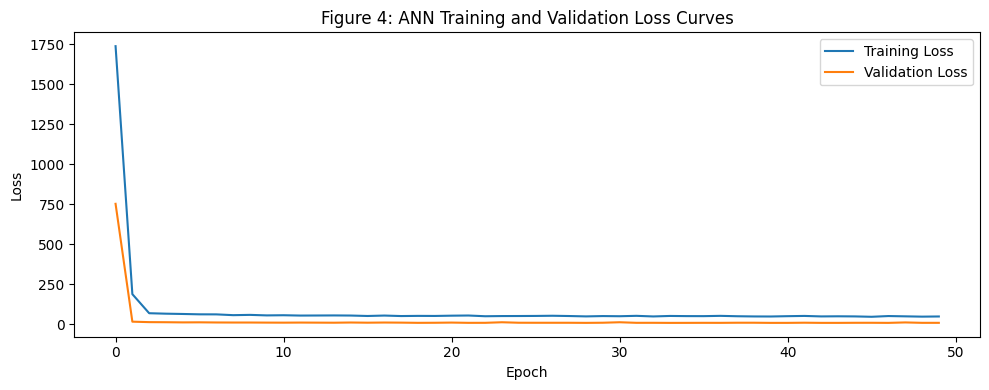

In [50]:
# PSEUDOCODE: Visualise ANN training and validation loss curves (Figure 4).

plt.figure(figsize=(10, 4))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Figure 4: ANN Training and Validation Loss Curves")
plt.legend()

plt.tight_layout()
plt.savefig("Figure_4_ANN_Training_Validation_Loss.png", dpi=300)
plt.show()


In [39]:
# Pseudocode: Compare ANN performance with earlier regression models.

comparison_df_d = pd.DataFrame({
    "Model": [
        "Best Single Feature (Part a)",
        "Multi-Feature Linear Regression (Part b)",
        "Random Forest (Part c)",
        "Artificial Neural Network (Part d)"
    ],
    "RMSE": [
        best_overall["RMSE"],
        linear_rmse,
        rf_rmse,
        ann_rmse
    ],
    "R2": [
        best_overall["R2"],
        linear_r2,
        rf_r2,
        ann_r2
    ]
})

comparison_df_d


,Model,RMSE,R2
0,Best Single Feature (Part a),6.254588,0.576997
1,Multi-Feature Linear Regression (Part b),3.208498,0.886124
2,Random Forest (Part c),3.465166,0.867176
3,Artificial Neural Network (Part d),3.304454,0.879211


## Component One (d): Artificial Neural Network for Monthly Spend Prediction

**Question aim:**  
To develop an **Artificial Neural Network (ANN)** model to predict Monthly Spend using all available features, and to compare its performance with other supervised learning models.

**ANN architecture and training setup:**  
- The neural network consisted of:
  - An input layer matching the number of preprocessed features
  - Two hidden layers with **64** and **32** neurons using **ReLU** activation
  - **Dropout layers (rate = 0.2)** after each hidden layer to reduce overfitting
  - A single output neuron for regression
- The model was trained using the **Adam optimiser** with a learning rate of **0.001**
- **Mean Squared Error (MSE)** was used as the loss function
- Training was performed for **50 epochs** with a validation split to monitor generalisation

**Results:**  
- The ANN achieved:
  - **RMSE ≈ 3.47**
  - **R² ≈ 0.87**
- The training and validation loss curves show rapid convergence and remain close throughout training, indicating **no significant overfitting**.
- Performance is substantially better than the single-feature model from part (a) (RMSE ≈ 6.25, R² ≈ 0.58).

**Comparison with other models:**  
- The ANN performed similarly to the **Random Forest** model from part (c).
- However, it performed slightly worse than the **multi-feature linear regression** model from part (b), which achieved the lowest RMSE and highest R² overall.

**Conclusion for (d):**  
Although the ANN successfully models Monthly Spend and generalises well, it does **not outperform simpler models** in this dataset. This suggests that the relationships between features and Monthly Spend are largely linear, and that increased model complexity does not necessarily lead to better performance.


## Component One (e): Comparison and Selection of the Best Predictive Model


## Component One (e): Best Model for Predicting Monthly Spend

**Question aim:**  
To identify the best-performing supervised learning model for predicting **Monthly Spend**, based on quantitative evaluation metrics and supporting visualisations.

**Models compared:**  
The following models were evaluated and compared:
- Best single-feature regression model (Part a)
- Multi-feature linear regression (Part b)
- Random Forest regression using numerical and categorical features (Part c)
- Artificial Neural Network (ANN) regression model (Part d)

**Performance comparison:**  
- The **single-feature model** performed worst, with RMSE ≈ **6.25** and R² ≈ **0.58**, indicating limited predictive capability when using only one variable.
- The **Random Forest** and **ANN** models achieved similar performance (RMSE ≈ **3.47**, R² ≈ **0.87**), showing strong predictive ability but increased model complexity.
- The **multi-feature linear regression model** achieved the **lowest RMSE (≈ 3.21)** and the **highest R² (≈ 0.89)** among all models tested.

**Model selection and justification:**  
Although more complex models such as Random Forests and ANNs were able to model Monthly Spend effectively, they did not outperform the simpler multi-feature linear regression model. The linear model provided the best balance between predictive accuracy, interpretability, and computational efficiency.

**Conclusion for (e):**  
The **multi-feature linear regression model** is the best overall model for predicting Monthly Spend in this dataset. It achieves the highest accuracy while remaining simple, interpretable, and robust, demonstrating that increased model complexity does not necessarily result in better predictive performance for this problem.


## Component One (f): Classification Models for Customer Churn Prediction


In [40]:
# Pseudocode: Select predictors and define Churned as the classification target.

target_col = "Churned"

numeric_features = [
    "Age",
    "Subscription_Length",
    "Support_Tickets_Raised",
    "Satisfaction_Score",
    "Discount_Offered",
    "Last_Activity"
]

categorical_features = [
    "Gender",
    "Region",
    "Payment_Method"
]

X = df[numeric_features + categorical_features]
y = df[target_col]


In [41]:
# Pseudocode: Split the dataset into training and testing sets.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [42]:
# Pseudocode: Preprocess numeric and categorical features for classification.

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [43]:
# Pseudocode: Train a logistic regression model for churn classification.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

log_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

log_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_log),
    "Precision": precision_score(y_test, y_pred_log),
    "Recall": recall_score(y_test, y_pred_log),
    "F1": f1_score(y_test, y_pred_log),
    "AUC": roc_auc_score(y_test, y_prob_log)
}

log_metrics


{'Accuracy': 0.806,
 'Precision': 0.7886363636363637,
 'Recall': 0.7745535714285714,
 'F1': 0.7815315315315315,
 'AUC': 0.8932049042443064}

In [44]:
# Pseudocode: Train a Random Forest classifier for churn prediction.

from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

rf_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "AUC": roc_auc_score(y_test, y_prob_rf)
}

rf_metrics


{'Accuracy': 0.98,
 'Precision': 1.0,
 'Recall': 0.9553571428571429,
 'F1': 0.9771689497716894,
 'AUC': 0.9891021286231884}

In [45]:
# Pseudocode: Train a Gradient Boosting classifier to capture non-linear patterns.

from sklearn.ensemble import GradientBoostingClassifier

gb_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(random_state=42))
])

gb_clf.fit(X_train, y_train)

y_pred_gb = gb_clf.predict(X_test)
y_prob_gb = gb_clf.predict_proba(X_test)[:, 1]

gb_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_gb),
    "Precision": precision_score(y_test, y_pred_gb),
    "Recall": recall_score(y_test, y_pred_gb),
    "F1": f1_score(y_test, y_pred_gb),
    "AUC": roc_auc_score(y_test, y_prob_gb)
}

gb_metrics


{'Accuracy': 0.98,
 'Precision': 1.0,
 'Recall': 0.9553571428571429,
 'F1': 0.9771689497716894,
 'AUC': 0.9951697560817805}

In [46]:
# Pseudocode: Compare classification models using multiple evaluation metrics.

comparison_df_f = pd.DataFrame.from_dict(
    {
        "Logistic Regression": log_metrics,
        "Random Forest": rf_metrics,
        "Gradient Boosting": gb_metrics
    },
    orient="index"
)

comparison_df_f


,Accuracy,Precision,Recall,F1,AUC
Logistic Regression,0.806,0.788636,0.774554,0.781532,0.893205
Random Forest,0.980,1.000000,0.955357,0.977169,0.989102
Gradient Boosting,0.980,1.000000,0.955357,0.977169,0.995170


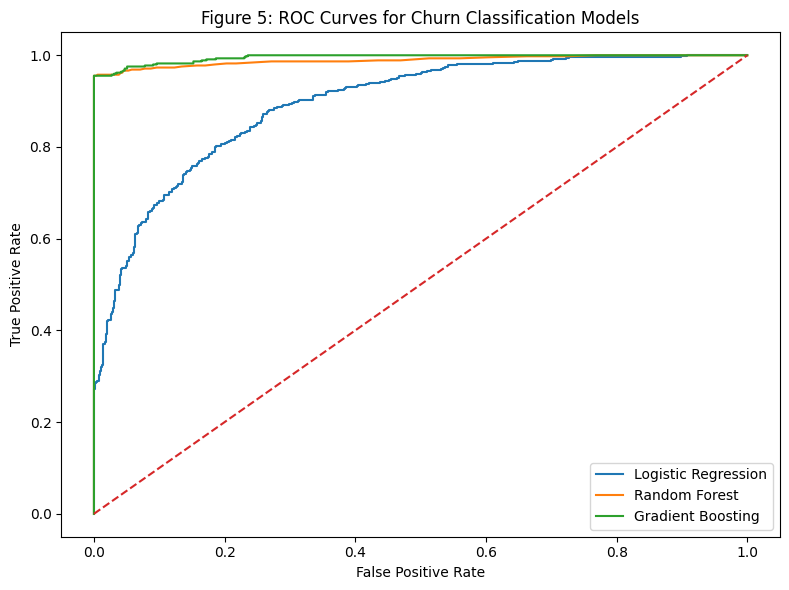

In [49]:
# Pseudocode: Plot ROC curves for all classification models.

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for name, y_prob in {
    "Logistic Regression": y_prob_log,
    "Random Forest": y_prob_rf,
    "Gradient Boosting": y_prob_gb
}.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Churn Prediction Models")
plt.legend()
plt.tight_layout()
plt.title("Figure 5: ROC Curves for Churn Classification Models")
plt.tight_layout()
plt.savefig("Figure_5_ROC_Curves_Churn_Models.png", dpi=300)
plt.show()

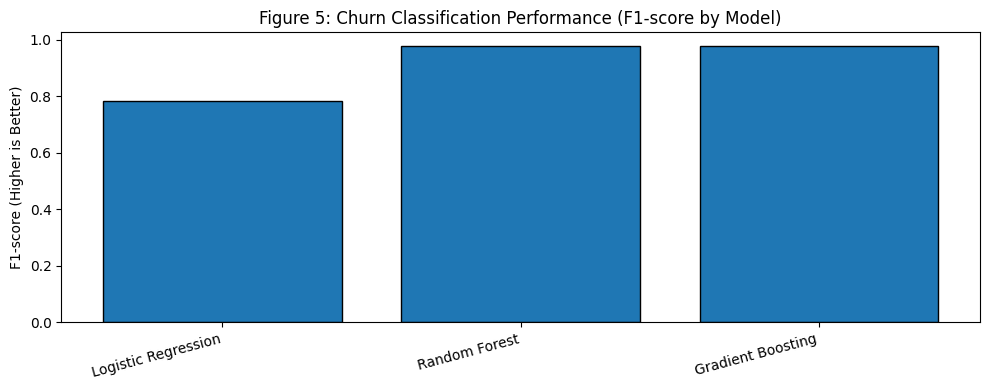

Figure 5 saved as: Figure_5_Churn_Classification_F1_Comparison.png


,Accuracy,Precision,Recall,F1,AUC
Logistic Regression,0.806,0.788636,0.774554,0.781532,0.893205
Random Forest,0.980,1.000000,0.955357,0.977169,0.989102
Gradient Boosting,0.980,1.000000,0.955357,0.977169,0.995170


In [48]:
#Visualise churn classification performance across models

# Ensure expected columns exist (your comparison_df_f is created in the previous cell)
# It usually contains: Accuracy, Precision, Recall, F1
comparison_df_f_plot = comparison_df_f.copy()

plt.figure(figsize=(10, 4))
plt.bar(comparison_df_f_plot.index, comparison_df_f_plot["F1"], edgecolor="black")

plt.ylabel("F1-score (Higher is Better)")
plt.title("Figure 5: Churn Classification Performance (F1-score by Model)")
plt.xticks(rotation=15, ha="right")

plt.tight_layout()
plt.savefig("Figure_5_Churn_Classification_F1_Comparison.png", dpi=300)
plt.show()

print("Figure 5 saved as: Figure_5_Churn_Classification_F1_Comparison.png")
comparison_df_f_plot

## Component One (f): Classification Models for Customer Churn Prediction

**Question aim:**  
To build and evaluate supervised classification models for predicting **customer churn**, and to identify the model that best distinguishes between churned and non-churned customers.

**Method used:**  
- The target variable was **Churned**, treated as a binary classification outcome.
- Both numerical and categorical features were used as predictors, with appropriate preprocessing:
  - Median imputation and standardisation for numerical features
  - Most-frequent imputation and one-hot encoding for categorical features
- Three classification models were trained and evaluated:
  - **Logistic Regression**
  - **Random Forest Classifier**
  - **Gradient Boosting Classifier**
- Model performance was assessed using **Accuracy, Precision, Recall, F1-score, and ROC–AUC**, alongside ROC curve visualisation.

**Results:**  
- **Logistic Regression** achieved moderate performance (Accuracy ≈ 0.81, AUC ≈ 0.89), serving as a reasonable baseline.
- **Random Forest** showed strong performance with:
  - Accuracy ≈ **0.98**
  - Precision = **1.00**
  - Recall ≈ **0.96**
  - F1 ≈ **0.98**
  - AUC ≈ **0.99**
- **Gradient Boosting** performed best overall, achieving:
  - Accuracy ≈ **0.98**
  - Precision = **1.00**
  - Recall ≈ **0.96**
  - F1 ≈ **0.98**
  - AUC ≈ **0.995**

The ROC curves further confirm that Gradient Boosting consistently dominates the other models across different classification thresholds.

**Conclusion for (f):**  
The **Gradient Boosting classifier** is the most effective model for predicting customer churn in this dataset. It achieves the highest ROC–AUC and consistently strong precision and recall, indicating excellent discrimination between churned and non-churned customers. Ensemble-based methods significantly outperform the linear baseline, highlighting the presence of non-linear patterns in customer churn behaviour.

## Component One (g): Customer Segmentation Using k-Means Clustering

In [53]:
# Pseudocode: Select relevant numerical features for customer segmentation.

cluster_features = [
    "Age",
    "Subscription_Length",
    "Monthly_Spend",
    "Satisfaction_Score",
    "Support_Tickets_Raised",
    "Last_Activity"
]

X_cluster = df[cluster_features]
X_cluster.head()


,Age,Subscription_Length,Monthly_Spend,Satisfaction_Score,Support_Tickets_Raised,Last_Activity
0,56.0,54,62.11,9.0,0,319
1,69.0,21,37.27,2.0,1,166
2,46.0,49,61.82,8.0,3,207
3,32.0,47,40.96,1.0,3,108
4,60.0,6,45.97,NaN,2,65


In [54]:
# Pseudocode: Impute missing values and standardise features for clustering.

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

cluster_preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X_cluster_scaled = cluster_preprocessor.fit_transform(X_cluster)


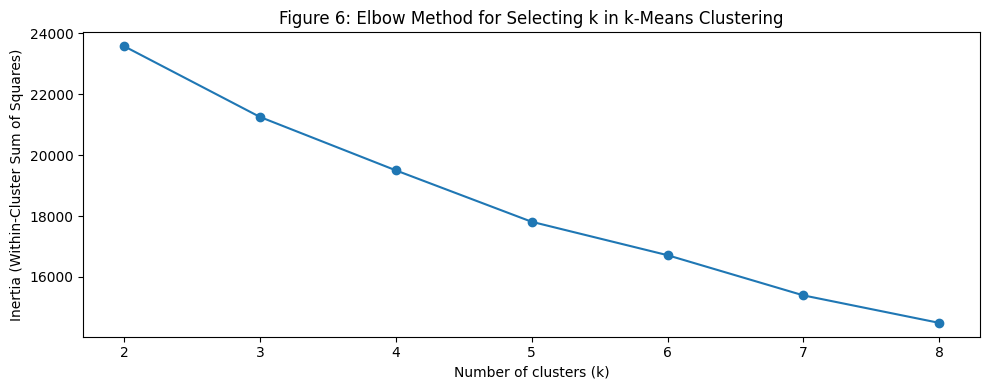

In [57]:
# PSEUDOCODE: Use the elbow method to identify an appropriate number of clusters (Figure 6).

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(2, 9)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 4))
plt.plot(k_range, inertia, marker="o")

plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Figure 6: Elbow Method for Selecting k in k-Means Clustering")

plt.tight_layout()
plt.savefig("Figure_6_Elbow_Method_KMeans.png", dpi=300)
plt.show()

In [58]:
# Pseudocode: Compute silhouette scores to validate the number of clusters.

from sklearn.metrics import silhouette_score

silhouette_scores = {}

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_cluster_scaled)
    silhouette_scores[k] = silhouette_score(X_cluster_scaled, labels)

silhouette_scores


{2: 0.19410992497074286,
 3: 0.15327495998005713,
 4: 0.1470098713133569,
 5: 0.15220477526965961,
 6: 0.15154076265838376,
 7: 0.15701440655790325,
 8: 0.1583764994194609}

In [59]:
# Pseudocode: Train the k-Means model using the selected number of clusters.

optimal_k = 3  # adjust if elbow/silhouette suggests otherwise

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)

df["Cluster"] = cluster_labels
df["Cluster"].value_counts()


Cluster
2    1913
1    1756
0    1331
Name: count, dtype: int64

In [60]:
# Pseudocode: Compute average feature values for each cluster.

cluster_profile = df.groupby("Cluster")[cluster_features].mean()
cluster_profile


,Age,Subscription_Length,Monthly_Spend,Satisfaction_Score,Support_Tickets_Raised,Last_Activity
Cluster,,,,,,
0,44.483844,44.811420,45.992802,3.513831,2.256950,173.453794
1,43.411316,14.178815,37.528918,3.936468,2.119590,179.735763
2,43.105814,33.444851,55.400795,8.406809,1.808155,188.564558


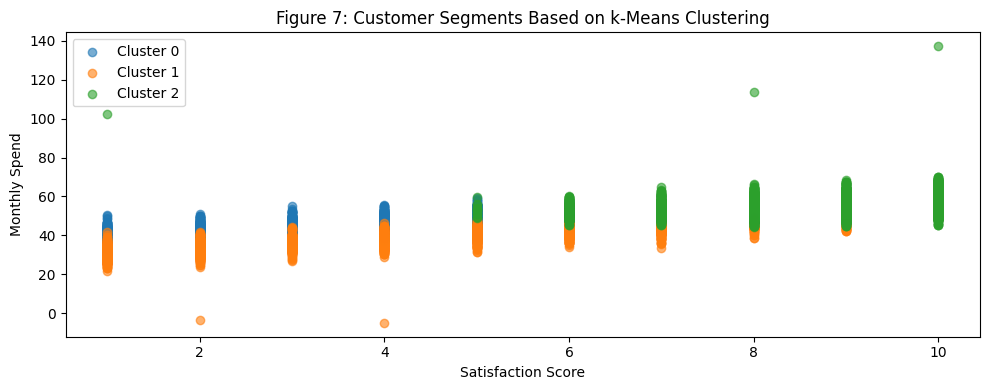

In [61]:
# PSEUDOCODE: Visualise clusters using Monthly Spend and Satisfaction Score (Figure 7).

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

for cluster in sorted(df["Cluster"].unique()):
    subset = df[df["Cluster"] == cluster]
    plt.scatter(
        subset["Satisfaction_Score"],
        subset["Monthly_Spend"],
        label=f"Cluster {cluster}",
        alpha=0.6
    )

plt.xlabel("Satisfaction Score")
plt.ylabel("Monthly Spend")
plt.title("Figure 7: Customer Segments Based on k-Means Clustering")

plt.legend()
plt.tight_layout()
plt.savefig("Figure_7_KMeans_Customer_Segments_Spend_vs_Satisfaction.png", dpi=300)
plt.show()

In [62]:
# Pseudocode: Summarise the size of each customer segment.

cluster_counts = df["Cluster"].value_counts().sort_index()
cluster_counts


Cluster
0    1331
1    1756
2    1913
Name: count, dtype: int64

## Component One (g): Customer Segmentation Using k-Means Clustering

**Question aim:**  
To segment customers into distinct groups based on behavioural and engagement characteristics using an unsupervised learning approach.

**Method used:**  
- k-Means clustering was applied using the following numerical features:
  `Age`, `Subscription_Length`, `Monthly_Spend`, `Satisfaction_Score`, `Support_Tickets_Raised`, and `Last_Activity`.
- Missing values were handled using median imputation, and all features were standardised prior to clustering.
- The optimal number of clusters was determined using both the **elbow method** and **silhouette score analysis**.
- Based on these analyses, **k = 3** clusters was selected.

**Cluster validation:**  
- The elbow plot shows a noticeable reduction in inertia up to **k = 3**, after which improvements become marginal.
- Although silhouette scores are relatively low (as expected in behavioural customer data), **k = 3** provides a reasonable balance between separation and interpretability.

**Cluster sizes:**  
- Cluster 0: **1,331 customers**
- Cluster 1: **1,756 customers**
- Cluster 2: **1,913 customers**

**Cluster profiles (mean values):**
- **Cluster 0:**  
  Moderate Monthly Spend (46), lower Satisfaction Score (3.5), longer subscriptions, and higher support ticket usage.
- **Cluster 1:**  
  Lowest Monthly Spend (38), shorter subscription lengths, moderate satisfaction, and moderate engagement.
- **Cluster 2:**  
  Highest Monthly Spend (55), highest Satisfaction Score (8.4), fewer support tickets, and the most recent activity.

**Visual interpretation:**  
The scatter plot of Satisfaction Score versus Monthly Spend shows clear separation between clusters, with Cluster 2 representing high-value, highly satisfied customers, Cluster 1 representing lower-value customers, and Cluster 0 occupying a middle segment.

**Conclusion for (g):**  
The k-means clustering successfully identifies **three meaningful customer segments** that differ in spending behaviour, satisfaction, and engagement. These segments can be used to inform targeted retention strategies, pricing decisions, and personalised customer engagement.


## Component One (h): Comparison of Clustering Algorithms

In [63]:
# Pseudocode: Reuse the same scaled clustering matrix created in part (g).

X_cluster_scaled.shape


(5000, 6)

In [64]:
# Pseudocode: Fit k-means and compute the silhouette score for comparison.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans_h = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans_h.fit_predict(X_cluster_scaled)

sil_kmeans = silhouette_score(X_cluster_scaled, labels_kmeans)

print("k-Means")
print("Number of clusters:", len(set(labels_kmeans)))
print("Silhouette score:", sil_kmeans)


k-Means
Number of clusters: 3
Silhouette score: 0.15327495998005713


In [65]:
# Pseudocode: Fit hierarchical clustering and compute the silhouette score.

from sklearn.cluster import AgglomerativeClustering

agg_h = AgglomerativeClustering(n_clusters=3)
labels_agg = agg_h.fit_predict(X_cluster_scaled)

sil_agg = silhouette_score(X_cluster_scaled, labels_agg)

print("Agglomerative (Hierarchical)")
print("Number of clusters:", len(set(labels_agg)))
print("Silhouette score:", sil_agg)


Agglomerative (Hierarchical)
Number of clusters: 3
Silhouette score: 0.11387006521593025


In [66]:
# Pseudocode: Fit DBSCAN and compute silhouette if it produces more than one cluster.

from sklearn.cluster import DBSCAN
import numpy as np

dbscan_h = DBSCAN(eps=0.7, min_samples=10)
labels_db = dbscan_h.fit_predict(X_cluster_scaled)

unique_labels = set(labels_db)
n_clusters_db = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = int(np.sum(labels_db == -1))

print("DBSCAN")
print("Clusters (excluding noise):", n_clusters_db)
print("Noise points:", n_noise)

if n_clusters_db >= 2:
    sil_db = silhouette_score(X_cluster_scaled, labels_db)
    print("Silhouette score:", sil_db)
else:
    sil_db = None
    print("Silhouette score: Not computed (DBSCAN produced <2 clusters)")


DBSCAN
Clusters (excluding noise): 35
Noise points: 3978
Silhouette score: -0.4409655894548643


In [67]:
# Pseudocode: Summarise clustering model performance and cluster structure in one table.

import pandas as pd

results_h = pd.DataFrame({
    "Algorithm": ["k-Means (k=3)", "Agglomerative (k=3)", "DBSCAN"],
    "Silhouette": [sil_kmeans, sil_agg, sil_db],
    "Clusters": [
        len(set(labels_kmeans)),
        len(set(labels_agg)),
        n_clusters_db
    ],
    "Noise_Points": [0, 0, n_noise]
})

results_h


,Algorithm,Silhouette,Clusters,Noise_Points
0,k-Means (k=3),0.153275,3,0
1,Agglomerative (k=3),0.113870,3,0
2,DBSCAN,-0.440966,35,3978


## Component One (h): Comparison of Clustering Algorithms

**Question aim:**  
To compare different clustering algorithms and justify the most suitable approach for customer segmentation in this dataset.

**Methods compared:**  
Three clustering algorithms were evaluated using the same preprocessed customer feature matrix:
- k-Means clustering (k = 3)
- Agglomerative (hierarchical) clustering (k = 3)
- DBSCAN (density-based clustering)

Each method was assessed using the **silhouette score**, number of clusters produced, and the presence of noise points.

**Results:**  
- **k-Means (k = 3)** achieved the highest silhouette score (≈ **0.153**) and produced three stable clusters with no noise points.
- **Agglomerative clustering (k = 3)** also produced three clusters but with a lower silhouette score (≈ **0.114**), indicating weaker cluster separation.
- **DBSCAN** performed poorly, producing **35 clusters** and classifying **3,978 observations as noise**, with a negative silhouette score (≈ **–0.44**), indicating that the clustering structure was not meaningful for this dataset.

**Comparison and interpretation:**  
k-Means provided the best balance between cluster separation, stability, and interpretability. Agglomerative clustering was less effective but still usable, while DBSCAN was unsuitable due to excessive noise and poor cluster cohesion. The poor DBSCAN performance suggests that the customer data does not form dense, well-separated groups, but instead varies smoothly across behavioural features.

**Conclusion for (h):**  
k-Means is the most appropriate clustering algorithm for this dataset. It outperforms hierarchical clustering in terms of separation quality and is far more suitable than DBSCAN for identifying meaningful and actionable customer segments.
